# Training in Brax with PyTorch on GPUs

Brax is ready to integrate into other research toolkits by way of the [OpenAI Gym](https://gym.openai.com/) interface.  Brax environments convert to Gym environments using either [GymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for single environments, or [VectorGymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for batched (parallelized) environments.

In [1]:
#@title Import Brax and some helper modules
from IPython.display import clear_output

import collections
from datetime import datetime
import functools
import math
import os
import time
from typing import Any, Callable, Dict, Optional, Sequence

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax.envs import to_torch
from brax.io import metrics
from brax.training import ppo
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

Here is a PPO Agent written in PyTorch:

In [2]:
class Agent(nn.Module):
  """Standard PPO Agent with GAE and observation normalization."""

  def __init__(self,
               policy_layers: Sequence[int],
               value_layers: Sequence[int],
               entropy_cost: float,
               discounting: float,
               reward_scaling: float,
               device: str):
    super(Agent, self).__init__()

    policy = []
    for w1, w2 in zip(policy_layers, policy_layers[1:]):
      policy.append(nn.Linear(w1, w2))
      policy.append(nn.SiLU())
    policy.pop()  # drop the final activation
    self.policy = nn.Sequential(*policy)

    value = []
    for w1, w2 in zip(value_layers, value_layers[1:]):
      value.append(nn.Linear(w1, w2))
      value.append(nn.SiLU())
    value.pop()  # drop the final activation
    self.value = nn.Sequential(*value)

    self.num_steps = torch.zeros((), device=device)
    self.running_mean = torch.zeros(policy_layers[0], device=device)
    self.running_variance = torch.zeros(policy_layers[0], device=device)

    self.entropy_cost = entropy_cost
    self.discounting = discounting
    self.reward_scaling = reward_scaling
    self.lambda_ = 0.95
    self.epsilon = 0.3
    self.device = device

  @torch.jit.export
  def dist_create(self, logits):
    """Normal followed by tanh.

    torch.distribution doesn't work with torch.jit, so we roll our own."""
    loc, scale = torch.split(logits, logits.shape[-1] // 2, dim=-1)
    scale = F.softplus(scale) + .001
    return loc, scale

  @torch.jit.export
  def dist_sample_no_postprocess(self, loc, scale):
    return torch.normal(loc, scale)

  @classmethod
  def dist_postprocess(cls, x):
    return torch.tanh(x)

  @torch.jit.export
  def dist_entropy(self, loc, scale):
    log_normalized = 0.5 * math.log(2 * math.pi) + torch.log(scale)
    entropy = 0.5 + log_normalized
    entropy = entropy * torch.ones_like(loc)
    dist = torch.normal(loc, scale)
    log_det_jacobian = 2 * (math.log(2) - dist - F.softplus(-2 * dist))
    entropy = entropy + log_det_jacobian
    return entropy.sum(dim=-1)

  @torch.jit.export
  def dist_log_prob(self, loc, scale, dist):
    log_unnormalized = -0.5 * ((dist - loc) / scale).square()
    log_normalized = 0.5 * math.log(2 * math.pi) + torch.log(scale)
    log_det_jacobian = 2 * (math.log(2) - dist - F.softplus(-2 * dist))
    log_prob = log_unnormalized - log_normalized - log_det_jacobian
    return log_prob.sum(dim=-1)

  @torch.jit.export
  def update_normalization(self, observation):
    self.num_steps += observation.shape[0] * observation.shape[1]
    input_to_old_mean = observation - self.running_mean
    mean_diff = torch.sum(input_to_old_mean / self.num_steps, dim=(0, 1))
    self.running_mean = self.running_mean + mean_diff
    input_to_new_mean = observation - self.running_mean
    var_diff = torch.sum(input_to_new_mean * input_to_old_mean, dim=(0, 1))
    self.running_variance = self.running_variance + var_diff

  @torch.jit.export
  def normalize(self, observation):
    variance = self.running_variance / (self.num_steps + 1.0)
    variance = torch.clip(variance, 1e-6, 1e6)
    return ((observation - self.running_mean) / variance.sqrt()).clip(-5, 5)

  @torch.jit.export
  def get_logits_action(self, observation):
    observation = self.normalize(observation)
    logits = self.policy(observation)
    loc, scale = self.dist_create(logits)
    action = self.dist_sample_no_postprocess(loc, scale)
    return logits, action

  @torch.jit.export
  def compute_gae(self, truncation, termination, reward, values,
                  bootstrap_value):
    truncation_mask = 1 - truncation
    # Append bootstrapped value to get [v1, ..., v_t+1]
    values_t_plus_1 = torch.cat(
        [values[1:], torch.unsqueeze(bootstrap_value, 0)], dim=0)
    deltas = reward + self.discounting * (
        1 - termination) * values_t_plus_1 - values
    deltas *= truncation_mask

    acc = torch.zeros_like(bootstrap_value)
    vs_minus_v_xs = torch.zeros_like(truncation_mask)

    for ti in range(truncation_mask.shape[0]):
      ti = truncation_mask.shape[0] - ti - 1
      acc = deltas[ti] + self.discounting * (
          1 - termination[ti]) * truncation_mask[ti] * self.lambda_ * acc
      vs_minus_v_xs[ti] = acc

    # Add V(x_s) to get v_s.
    vs = vs_minus_v_xs + values
    vs_t_plus_1 = torch.cat([vs[1:], torch.unsqueeze(bootstrap_value, 0)], 0)
    advantages = (reward + self.discounting *
                  (1 - termination) * vs_t_plus_1 - values) * truncation_mask
    return vs, advantages

  @torch.jit.export
  def loss(self, td: Dict[str, torch.Tensor]):
    observation = self.normalize(td['observation'])
    policy_logits = self.policy(observation[:-1])
    baseline = self.value(observation)
    baseline = torch.squeeze(baseline, dim=-1)

    # Use last baseline value (from the value function) to bootstrap.
    bootstrap_value = baseline[-1]
    baseline = baseline[:-1]
    reward = td['reward'] * self.reward_scaling
    termination = td['done'] * (1 - td['truncation'])

    loc, scale = self.dist_create(td['logits'])
    behaviour_action_log_probs = self.dist_log_prob(loc, scale, td['action'])
    loc, scale = self.dist_create(policy_logits)
    target_action_log_probs = self.dist_log_prob(loc, scale, td['action'])

    with torch.no_grad():
      vs, advantages = self.compute_gae(
          truncation=td['truncation'],
          termination=termination,
          reward=reward,
          values=baseline,
          bootstrap_value=bootstrap_value)

    rho_s = torch.exp(target_action_log_probs - behaviour_action_log_probs)
    surrogate_loss1 = rho_s * advantages
    surrogate_loss2 = rho_s.clip(1 - self.epsilon,
                                 1 + self.epsilon) * advantages
    policy_loss = -torch.mean(torch.minimum(surrogate_loss1, surrogate_loss2))

    # Value function loss
    v_error = vs - baseline
    v_loss = torch.mean(v_error * v_error) * 0.5 * 0.5

    # Entropy reward
    entropy = torch.mean(self.dist_entropy(loc, scale))
    entropy_loss = self.entropy_cost * -entropy

    return policy_loss + v_loss + entropy_loss

Finally, some code for unrolling and batching environment data:

In [3]:
StepData = collections.namedtuple(
    'StepData',
    ('observation', 'logits', 'action', 'reward', 'done', 'truncation'))


def sd_map(f: Callable[..., torch.Tensor], *sds) -> StepData:
  """Map a function over each field in StepData."""
  items = {}
  keys = sds[0]._asdict().keys()
  for k in keys:
    items[k] = f(*[sd._asdict()[k] for sd in sds])
  return StepData(**items)


def eval_unroll(agent, env, length):
  """Return number of episodes and average reward for a single unroll."""
  observation = env.reset()
  episodes = torch.zeros((), device=agent.device)
  episode_reward = torch.zeros((), device=agent.device)
  for _ in range(length):
    _, action = agent.get_logits_action(observation)
    observation, reward, done, _ = env.step(Agent.dist_postprocess(action))
    episodes += torch.sum(done)
    episode_reward += torch.sum(reward)
  return episodes, episode_reward / episodes


def train_unroll(agent, env, observation, num_unrolls, unroll_length):
  """Return step data over multple unrolls."""
  sd = StepData([], [], [], [], [], [])
  for _ in range(num_unrolls):
    one_unroll = StepData([observation], [], [], [], [], [])
    for _ in range(unroll_length):
      logits, action = agent.get_logits_action(observation)
      observation, reward, done, info = env.step(Agent.dist_postprocess(action))
      one_unroll.observation.append(observation)
      one_unroll.logits.append(logits)
      one_unroll.action.append(action)
      one_unroll.reward.append(reward)
      one_unroll.done.append(done)
      one_unroll.truncation.append(info['truncation'])
    one_unroll = sd_map(torch.stack, one_unroll)
    sd = sd_map(lambda x, y: x + [y], sd, one_unroll)
  td = sd_map(torch.stack, sd)
  return observation, td


def train(
    env_name: str = 'ant',
    num_envs: int = 2048,
    episode_length: int = 1000,
    device: str = 'cuda',
    num_timesteps: int = 30_000_000,
    eval_frequency: int = 10,
    unroll_length: int = 5,
    batch_size: int = 1024,
    num_minibatches: int = 32,
    num_update_epochs: int = 4,
    reward_scaling: float = .1,
    entropy_cost: float = 1e-2,
    discounting: float = .97,
    learning_rate: float = 3e-4,
    progress_fn: Optional[Callable[[int, Dict[str, Any]], None]] = None,
):
  """Trains a policy via PPO."""
  gym_name = f'brax-{env_name}-v0'
  if gym_name not in gym.envs.registry.env_specs:
    entry_point = functools.partial(envs.create_gym_env, env_name=env_name)
    gym.register(gym_name, entry_point=entry_point)
  env = gym.make(gym_name, batch_size=num_envs, episode_length=episode_length)
  # automatically convert between jax ndarrays and torch tensors:
  env = to_torch.JaxToTorchWrapper(env, device=device)

  # env warmup
  env.reset()
  action = torch.zeros(env.action_space.shape).to(device)
  env.step(action)

  # create the agent
  policy_layers = [
      env.observation_space.shape[-1], 64, 64, env.action_space.shape[-1] * 2
  ]
  value_layers = [env.observation_space.shape[-1], 64, 64, 1]
  agent = Agent(policy_layers, value_layers, entropy_cost, discounting,
                reward_scaling, device)
  agent = torch.jit.script(agent.to(device))
  optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

  sps = 0
  total_steps = 0
  total_loss = 0
  for eval_i in range(eval_frequency + 1):
    if progress_fn:
      t = time.time()
      with torch.no_grad():
        episode_count, episode_reward = eval_unroll(agent, env, episode_length)
      duration = time.time() - t
      # TODO: only count stats from completed episodes
      episode_avg_length = env.num_envs * episode_length / episode_count
      eval_sps = env.num_envs * episode_length / duration
      progress = {
          'eval/episode_reward': episode_reward,
          'eval/completed_episodes': episode_count,
          'eval/avg_episode_length': episode_avg_length,
          'speed/sps': sps,
          'speed/eval_sps': eval_sps,
          'losses/total_loss': total_loss,
      }
      progress_fn(total_steps, progress)

    if eval_i == eval_frequency:
      break

    observation = env.reset()
    num_steps = batch_size * num_minibatches * unroll_length
    num_epochs = num_timesteps // (num_steps * eval_frequency)
    num_unrolls = batch_size * num_minibatches // env.num_envs
    total_loss = 0
    t = time.time()
    for _ in range(num_epochs):
      observation, td = train_unroll(agent, env, observation, num_unrolls,
                                     unroll_length)

      # make unroll first
      def unroll_first(data):
        data = data.swapaxes(0, 1)
        return data.reshape([data.shape[0], -1] + list(data.shape[3:]))
      td = sd_map(unroll_first, td)

      # update normalization statistics
      agent.update_normalization(td.observation)

      for _ in range(num_update_epochs):
        # shuffle and batch the data
        with torch.no_grad():
          permutation = torch.randperm(td.observation.shape[1], device=device)
          def shuffle_batch(data):
            data = data[:, permutation]
            data = data.reshape([data.shape[0], num_minibatches, -1] +
                                list(data.shape[2:]))
            return data.swapaxes(0, 1)
          epoch_td = sd_map(shuffle_batch, td)

        for minibatch_i in range(num_minibatches):
          td_minibatch = sd_map(lambda d: d[minibatch_i], epoch_td)
          loss = agent.loss(td_minibatch._asdict())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss

    duration = time.time() - t
    total_steps += num_epochs * num_steps
    total_loss = total_loss / (num_epochs * num_update_epochs * num_minibatches)
    sps = num_epochs * num_steps / duration

Let's go!

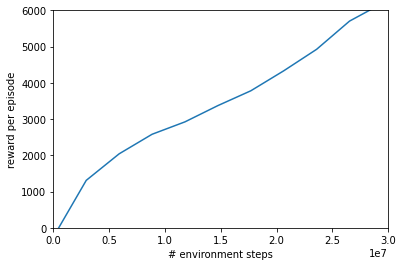

time to jit: 0:03:23.786113
time to train: 0:03:42.913398
eval steps/sec: 480208.42251490447
train steps/sec: 150517.30309979225
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-8bc7bf18-8df5-a5b8-1499-097e5c48c3db)


In [4]:
# temporary fix to cuda memory OOM
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

xdata = []
ydata = []
eval_sps = []
train_sps = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  eval_sps.append(metrics['speed/eval_sps'])
  train_sps.append(metrics['speed/sps'])
  clear_output(wait=True)
  plt.xlim([0, 30_000_000])
  plt.ylim([0, 6000])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

train(progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')
print(f'eval steps/sec: {np.mean(eval_sps)}')
print(f'train steps/sec: {np.mean(train_sps)}')
!nvidia-smi -L

In this arrangement, we can rollout environment steps much faster than we can train: the speed at which PyTorch can backpropagate the loss and step the optimizer is the bottleneck.  This PyTorch code can probably be sped up by adding [automatic mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html), and following other recommendations in the [PyTorch performance tuning guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html).

We know we have a fair bit of headroom to improve the PyTorch implementation, as the built-in Brax trainer (which uses [flax.optim](https://flax.readthedocs.io/en/latest/flax.optim.html)) runs at more than double the steps per second:

In [6]:
train_sps = []

def progress(_, metrics):
  train_sps.append(metrics['speed/sps'])

ppo.train(
    environment_fn=envs.create_fn(env_name='ant'), num_timesteps = 30_000_000,
    log_frequency = 10, reward_scaling = .1, episode_length = 1000,
    normalize_observations = True, action_repeat = 1, unroll_length = 5,
    num_minibatches = 32, num_update_epochs = 4, discounting = 0.97,
    learning_rate = 3e-4, entropy_cost = 1e-2, num_envs = 2048,
    batch_size = 1024, progress_fn = progress)

print(f'train steps/sec: {np.mean(train_sps[1:])}')

train steps/sec: 325783.03125


tunaalabagana! 👋